In [97]:
# !unzip '/content/drive/MyDrive/Colab Notebooks/ImageCaptioning/data/archive.zip' -d '/content/drive/MyDrive/Colab Notebooks/ImageCaptioning/data'

In [98]:
%cd /content/drive/MyDrive/Colab Notebooks/ImageCaptioning

/content/drive/MyDrive/Colab Notebooks/ImageCaptioning


In [99]:
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras

from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout, add
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3

from keras import Input
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model, save_model

# Dataset

In [100]:
df = pd.read_csv("data/captions.txt")

In [101]:
def plot_example(idx):
    """
    Choose idx in range 0 - 8090
    """
    # Plot image
    IMAGES_PATH = 'data/Images'
    image_name = df['image'][idx * 5]
    image = cv2.imread(os.path.join(IMAGES_PATH, image_name))
    print(f"Image's shape: {image.shape}")
    cv2_imshow(image)

    # Print captions
    print('Captions:')
    captions = df['caption'][5 * idx: 5 * idx + 5]
    for idx, values in captions.items():
        print(values)

Image's shape: (429, 500, 3)


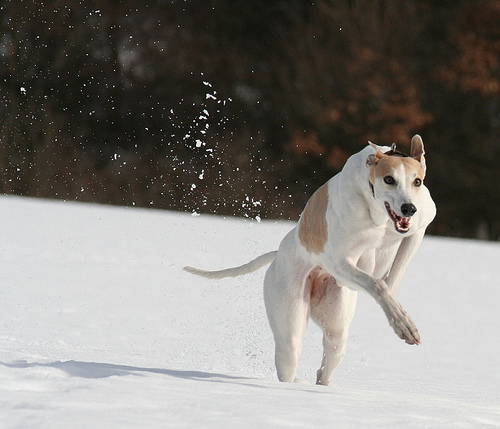

Captions:
A brown and white dog is running through the snow .
A dog is running in the snow
A dog running through snow .
a white and brown dog is running through a snow covered field .
The white and brown dog is running over the surface of the snow .


In [102]:
plot_example(10)

Image's shape: (500, 333, 3)


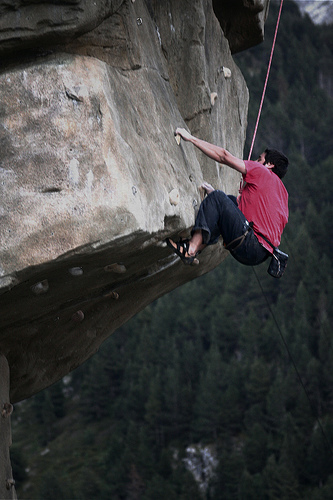

Captions:
A man in a pink shirt climbs a rock face
A man is rock climbing high in the air .
A person in a red shirt climbing up a rock face covered in assist handles .
A rock climber in a red shirt .
A rock climber practices on a rock climbing wall .


In [103]:
plot_example(8090)

# Tokenize

In [104]:
import string
import tensorflow as tf

In [105]:
@keras.saving.register_keras_serializable()
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [106]:
vocabulary_size = 2000

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)

In [107]:
captions = [item[1]['caption'] for item in df.iterrows()]
tokenizer.adapt(captions)
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']

# Data generator

In [108]:
def data_generator(df, tokenizer, max_length, batch_size):

  X_image, X_cap, y = [], [], []
  n = 0
  while 1:
    for i in range(8091):
        # Read image
        image_name = df['image'][i * 5]
        image = cv2.imread(os.path.join('data/Images', image_name))
        image = cv2.resize(image, (299, 299))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocess_input(image)

        # Read captions
        captions = df['caption'][5 * i: 5 * i + 5]
        for idx, cap in captions.items():
            # Encode the sequence
            seq = tokenizer(cap)

            for i in range(1, len(seq)):
                # Split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]

                # Padding input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                # Encode output sequence
                out_seq = to_categorical([out_seq], num_classes=tokenizer.vocabulary_size())[0]

                # Store
                n += 1
                X_image.append(image)
                X_cap.append(in_seq)
                y.append(out_seq)


                if n == batch_size:
                    X_cap = tf.convert_to_tensor(X_cap, dtype=tf.float32)
                    y = tf.convert_to_tensor(y, dtype=tf.float32)
                    X_image = tf.convert_to_tensor(X_image, dtype=tf.float32)

                    yield ([np.array(X_image), X_cap], np.array(y))
                    X_image, X_cap, y = [], [], []
                    n = 0

# Build model

In [109]:
@keras.saving.register_keras_serializable()

class ImageFeatureExtractionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

        pretrained_model = InceptionV3()
        feature_extraction = Model(pretrained_model.input, pretrained_model.layers[-2].output)
        feature_extraction.trainable = False

        self.image_fe_model = tf.keras.Sequential([
            Input(shape=(299, 299, 3)),
            feature_extraction,
            Dropout(0.5),
            Dense(256, activation='relu')
        ])

    def call(self, input):
        return self.image_fe_model(input)

    def get_config(self):
        config = super().get_config().copy()
        config.update({'image_fe_model': self.image_fe_model,})
        return config

In [110]:
@keras.saving.register_keras_serializable()

class TextFeatureExtractionLayer(tf.keras.layers.Layer):
    def __init__(self, VOCAB_SIZE, EMBEDDING_DIM, MAX_LENGTH):
        super().__init__()

        self.text_fe_model = tf.keras.Sequential([
            Input(shape=(MAX_LENGTH,)),
            Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True),
            Dropout(0.5),
            LSTM(256)
        ])

    def call(self, input):
        return self.text_fe_model(input)

    def get_config(self):
        config = super().get_config().copy()
        config.update({'text_fe_model': self.text_fe_model})
        return config

In [111]:
@keras.saving.register_keras_serializable()

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, VOCAB_SIZE, EMBEDDING_DIM, MAX_LENGTH):
        super().__init__()
        self.image_fe = ImageFeatureExtractionLayer()
        self.text_fe = TextFeatureExtractionLayer(VOCAB_SIZE, EMBEDDING_DIM, MAX_LENGTH)

        self.model = tf.keras.Sequential([
            Dense(256, activation='relu'),
            Dense(VOCAB_SIZE, activation='softmax')
        ])

    def call(self, input):
        image, text = input
        image_fe_in = self.image_fe(image)
        text_fe_in = self.text_fe(text)

        merge_fe = add([image_fe_in, text_fe_in])

        out = self.model(merge_fe)

        return out

    def get_config(self):
        config = super().get_config().copy()
        config.update({'image_fe': self.image_fe,
                'text_fe': self.text_fe,
                'model': self.model,}
        )
        return config

In [112]:
@keras.saving.register_keras_serializable()

class Captioner(tf.keras.Model):
    def __init__(self,
                 MAX_LENGTH,
                 EMBEDDING_DIM, **kwargs):
        super().__init__()
        self.tokenizer = tokenizer

        self.word_to_index = tf.keras.layers.StringLookup(
            mask_token="",
            vocabulary=tokenizer.get_vocabulary())

        self.index_to_word = tf.keras.layers.StringLookup(
            mask_token="",
            vocabulary=tokenizer.get_vocabulary(),
            invert=True)

        self.MAX_LENGTH = MAX_LENGTH
        self.EMBEDDING_DIM = EMBEDDING_DIM

        self.decoder = DecoderLayer(tokenizer.vocabulary_size(), EMBEDDING_DIM, MAX_LENGTH)

    def call(self, input):
        image, sequence = input
        pred = self.decoder([image, sequence])
        return pred

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'tokenizer': self.tokenizer,
            'index_to_word': self.index_to_word,
            'word_to_index': self.word_to_index,
            'MAX_LENGTH': self.MAX_LENGTH,
            'EMBEDDING_DIM': self.EMBEDDING_DIM,
            'decoder': self.decoder,
        })
        return config



    def generate_caption(self, image):
        image = cv2.resize(image, (299, 299))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocess_input(image)
        image = np.expand_dims(image, axis=0)

        y_pred = []
        in_text = '[START]'
        for i in range(self.MAX_LENGTH):
            sequence = tokenizer(in_text)
            sequence = pad_sequences([sequence], maxlen=self.MAX_LENGTH)
            yhat = self([image, sequence])
            yhat = np.argmax(yhat)
            if self.word_to_index('[END]') == tf.constant(yhat, dtype=tf.int64):
                break

            y_pred.append(yhat)

        words = self.index_to_word(y_pred[1:])
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        return result.numpy().decode()

In [114]:
EMBEDDING_DIM = 300
MAX_LENGTH = 40
EPOCHS = 1
BATCH_SIZE = 16
# STEPS = 8091 / BATCH_SIZE
STEPS = 1

CHECKPOIN_PATH = 'checkpoints/model-{epoch:02d}-{loss:.2f}.keras'
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model = Captioner(MAX_LENGTH, EMBEDDING_DIM)


model.compile(loss=loss,
              optimizer=optimizer)




# Train

In [115]:

my_callback = ModelCheckpoint(filepath=CHECKPOIN_PATH,
                              save_best_only=False,
                              verbose=1)

generator = data_generator(df=df,
                           tokenizer=tokenizer,
                           max_length=MAX_LENGTH,
                           batch_size=BATCH_SIZE)
# model.fit(generator,
#           epochs=EPOCHS,
#           steps_per_epoch=STEPS,
#           verbose=1,
#           callbacks=[my_callback])

model.fit(generator,
          epochs=EPOCHS,
          steps_per_epoch=STEPS,
          verbose=1)

1/1 [==============================] - 16s 16s/step - loss: 7.6655


In [116]:
model.save('models/model-v1.keras')

# Evaluate

In [117]:
reconstructed_model = load_model('models/model-v1.keras')

# Testing

In [118]:
image = cv2.imread('test_images/istockphoto-1186954832-612x612.jpg')
reconstructed_model.generate_caption(image)

'feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding feeding'